### Import needed libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import numpy as np
import os
import cv2
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

### Import dataset

In [2]:
# Set initial variables
mask_data_dir = "./data/trainvalidate/WithMask/"
nomask_data_dir = "./data/trainvalidate/WithoutMask/"
img_height = img_width = desired_size = 100
img_channels = 3
initialdata = []
labels = []
shapes = []

# Import images
for filename in os.listdir(mask_data_dir):
    img=cv2.imread(mask_data_dir+filename, cv2.IMREAD_UNCHANGED)
    b,g,r = cv2.split(img)       # get b, g, r
    img = cv2.merge([r,g,b])     # switch to r, g, b
    initialdata.append(img)
    labels.append(1)
    shapes.append(img.shape)
    
for filename in os.listdir(nomask_data_dir):
    img=cv2.imread(nomask_data_dir+filename, cv2.IMREAD_UNCHANGED)
    b,g,r = cv2.split(img)       # get b, g, r
    img = cv2.merge([r,g,b])     # switch to r, g, b
    initialdata.append(img)
    labels.append(0)
    shapes.append(img.shape)

print(f"The total number of images in the dataset is: {len(initialdata)}")

The total number of images in the dataset is: 6802


### Show sample images

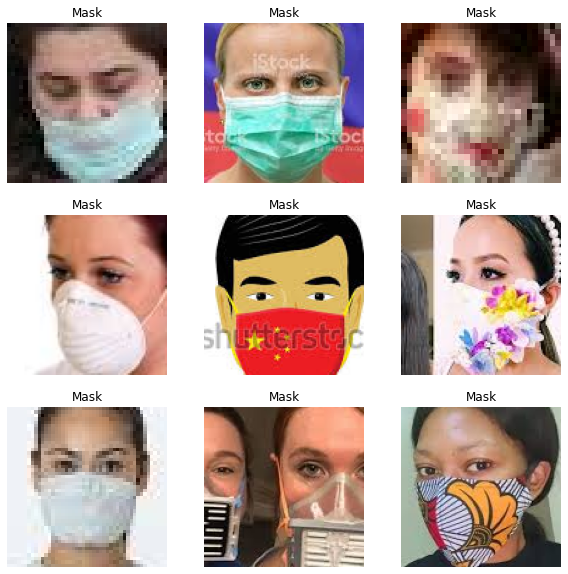

In [3]:
maskdict = ["No Mask", "Mask"]
plt.figure(figsize=(10, 10))
for i in range(10,19):
    ax = plt.subplot(3, 3, i + 1 -10)
    plt.imshow(initialdata[i].astype("uint8"))
    plt.title(maskdict[labels[i]])
    plt.axis("off")

### Check the shape of the images

The smallest height: 25
The smallest width: 25
The biggest height: 563
The biggest width: 563


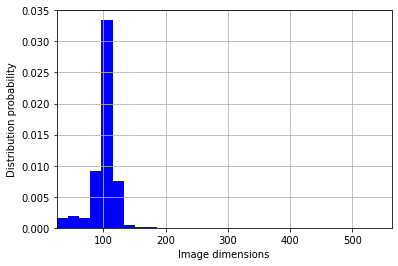

In [4]:
#Get smallest and biggest dimensions
smallestheight = biggestheight = shapes[0][0]
smallestwidth = biggestwidth = shapes[0][1]
for shape in shapes:
    if shape[0] < smallestheight:
        smallestheight = shape[0]
    if shape[0] > biggestheight:
        biggestheight = shape[0]
    if shape[1] < smallestwidth:
        smallestwidth = shape[1]
    if shape[1] > biggestwidth:
        biggestwidth = shape[1]

print(f"The smallest height: {smallestheight}")
print(f"The smallest width: {smallestwidth}")
print(f"The biggest height: {biggestheight}")
print(f"The biggest width: {biggestwidth}")
        
#Check if any images are not rectangular 
for shape in shapes:
    if shape[0] != shape[1]:
        print("Some images are not rectangular")
        break

#Extract one dimension from shape (doesnt matter which since images are rect), and then plot histogram
shapes_one_dimension = []
for shape in shapes:
    shapes_one_dimension.append(shape[0])

n, bins, patches = plt.hist(shapes_one_dimension, 30, density=1, facecolor='b')

plt.rcParams["figure.figsize"] = (12,8)
plt.xlabel('Image dimensions')
plt.ylabel('Distribution probability')
plt.axis([min(smallestheight, smallestwidth), max(biggestheight, biggestwidth), 0, 0.035])
plt.grid(True)
plt.show()

### Resize images , using 0 padding to maintain aspect ratio

In [5]:
# convert imported images into desired size
data = []
for im in initialdata:
    old_size = im.shape[:2]
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    new_im = cv2.resize(im, (new_size[1], new_size[0]), interpolation=cv2.INTER_CUBIC)

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(new_im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    data.append(new_im)

### Split dataset to Train, Validate, and Test sets

In [6]:
#Split data between train, validation, and test 
trainvalid_data, test_data, trainvalid_label, test_label = train_test_split(data, labels, test_size=0.05)
train_data, valid_data, train_label, valid_label = train_test_split(trainvalid_data, trainvalid_label, test_size=0.2)

#Convert lists back to numpy array
train_data = np.asarray(train_data)
valid_data = np.asarray(valid_data)
test_data = np.asarray(test_data)
train_label = np.asarray(train_label)
valid_label = np.asarray(valid_label)
test_label = np.asarray(test_label)

### Show count of each set then plot histogram

Dataset        Total Size     Without Mask   With Mask      
Total          6802           5909 (87.0%)   893 (13.0%)    
Training       5168           4495 (87.0%)   673 (13.0%)    
Validation     1293           1112 (86.0%)   181 (14.000000000000002%)
Test           341            302 (89.0%)    39 (11.0%)     


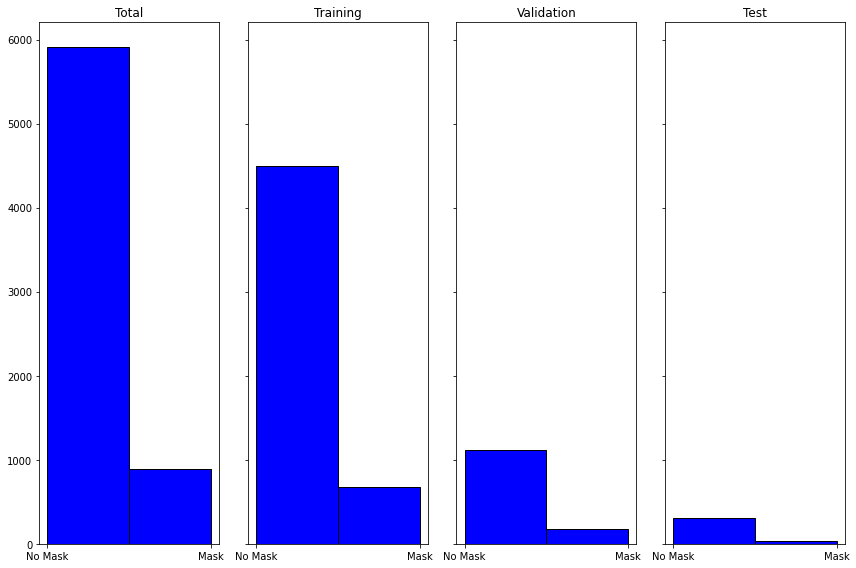

In [7]:
# Show table for count in each dataset
tableheader = ["Dataset", "Total Size", "Without Mask", "With Mask"]
tabledata = list()
format_row = "{:<15}" * (len(tableheader))
print(format_row.format(*tableheader))

labeldict = {"Total": labels, "Training": train_label, "Validation": valid_label, "Test": test_label}
for key in labeldict:
    total = len(labeldict[key])
    count_no_mask = count_with_mask = 0
    for label in labeldict[key]: 
        if label == 0: count_no_mask+=1
    count_with_mask = total-count_no_mask
    tabledata.append((str(key), str(total), str(count_no_mask) + " (" + str(round(count_no_mask/total, 2)*100) +"%)", str(count_with_mask) + " (" + str(round(count_with_mask/total, 2)*100) +"%)"))
    
for row in tabledata:
    print(format_row.format(*row))

# Plot the histogram
fig, axs = plt.subplots(1, len(labeldict), sharey=True, tight_layout=True)
graphnumber = 0
for key in labeldict:
    axs[graphnumber].set_title(str(key))
    axs[graphnumber].hist(labeldict[key], bins=2, color = 'blue', edgecolor = 'black')
    axs[graphnumber].set_xticks([0,1])
    axs[graphnumber].set_xticklabels(maskdict)
    graphnumber += 1


### Enable memory storage and prefetch (Disabling this for now, may use later)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Set the arguments(may use Grid Search later)

In [8]:
epochs=4
batch_size=100

### Data Augmentation

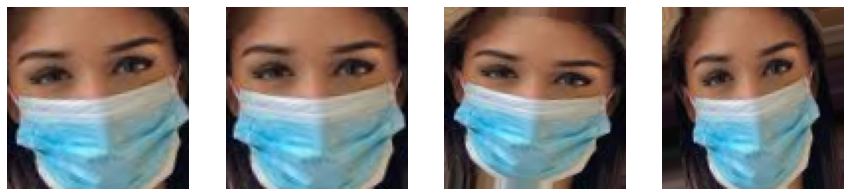

In [9]:
datagenerator = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

datagenerator.fit(train_data)

# Print sample of augmented image
image = load_img('data/trainvalidate/WithMask/148.png')
image_array = np.expand_dims(img_to_array(image), 0)
aug_iter = datagenerator.flow(image_array, batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')

### Model 1: Build and train (2 Conv Layers)

In [10]:
def build_model1():
    model1=Sequential()
    model1.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,img_channels)))
    model1.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2,2)))
    model1.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2,2)))
    model1.add(layers.Flatten())
    model1.add(layers.Dropout(rate=0.5))
    model1.add(layers.Dense(units=128,activation='relu'))
    model1.add(layers.Dense(units=1,activation='sigmoid'))

    model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model1

model1=build_model1()
model1.summary()

history1 = model1.fit(datagenerator.flow(train_data, train_label,batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=len(train_data) / batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / batch_size)

# Get the weights used in the model
weights = []
for layer in model1.layers:
    weights.append(layer.get_weights())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 40000)             0

### Model 2: Build and train (3 Conv Layers)

In [11]:
def build_model2():
    model2=Sequential()
    model2.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
    model2.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2,2)))
    model2.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2,2)))
    model2.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2,2)))
    model2.add(layers.Flatten())
    model2.add(layers.Dropout(rate=0.5))
    model2.add(layers.Dense(units=128,activation='relu'))
    model2.add(layers.Dense(units=1,activation='sigmoid'))

    model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model2

model2=build_model2()
model2.summary()

history2 = model2.fit(datagenerator.flow(train_data, train_label,batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=len(train_data) / batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)       

### Model 3: Build and train (4 Conv Layers)

In [12]:
def build_model3():
    model3=Sequential()
    model3.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
    model3.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu'))
    model3.add(layers.MaxPooling2D(pool_size=(2,2)))
    model3.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
    model3.add(layers.MaxPooling2D(pool_size=(2,2)))
    model3.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model3.add(layers.MaxPooling2D(pool_size=(2,2)))
    model3.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model3.add(layers.MaxPooling2D(pool_size=(2,2)))
    model3.add(layers.Flatten())
    model3.add(layers.Dropout(rate=0.5))
    model3.add(layers.Dense(units=128,activation='relu'))
    model3.add(layers.Dense(units=1,activation='sigmoid'))

    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model3

model3= build_model3()
model3.summary()

history3 = model3.fit(datagenerator.flow(train_data, train_label,batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=len(train_data) / batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / batch_size)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)       

### Model 4: Build and train (4 Conv Layers)

In [13]:
def build_model4():
    model4=Sequential()
    model4.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
    model4.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',name="conv1"))
    model4.add(layers.MaxPooling2D(pool_size=(2,2),name="maxp1"))
    model4.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',name="conv2"))
    model4.add(layers.MaxPooling2D(pool_size=(2,2),name="maxp2"))
    model4.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',name="conv3"))
    model4.add(layers.MaxPooling2D(pool_size=(2,2),name="maxp3"))
    model4.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',name="conv4"))
    model4.add(layers.MaxPooling2D(pool_size=(2,2),name="maxp4"))
    model4.add(layers.Flatten())
    model4.add(layers.Dropout(rate=0.5))
    model4.add(layers.Dense(units=128,activation='relu'))
    model4.add(layers.Dense(units=1,activation='sigmoid'))

    model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model4

model4=build_model4()
model4.summary()

history4 = model4.fit(datagenerator.flow(train_data, train_label,batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=len(train_data) / batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / batch_size)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      448       
_________________________________________________________________
maxp1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 32)        4640      
_________________________________________________________________
maxp2 (MaxPooling2D)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 25, 25, 64)        18496     
_________________________________________________________________
maxp3 (MaxPooling2D)         (None, 12, 12, 64)       

### Plot Model Training and Validation Accuracy and Loss

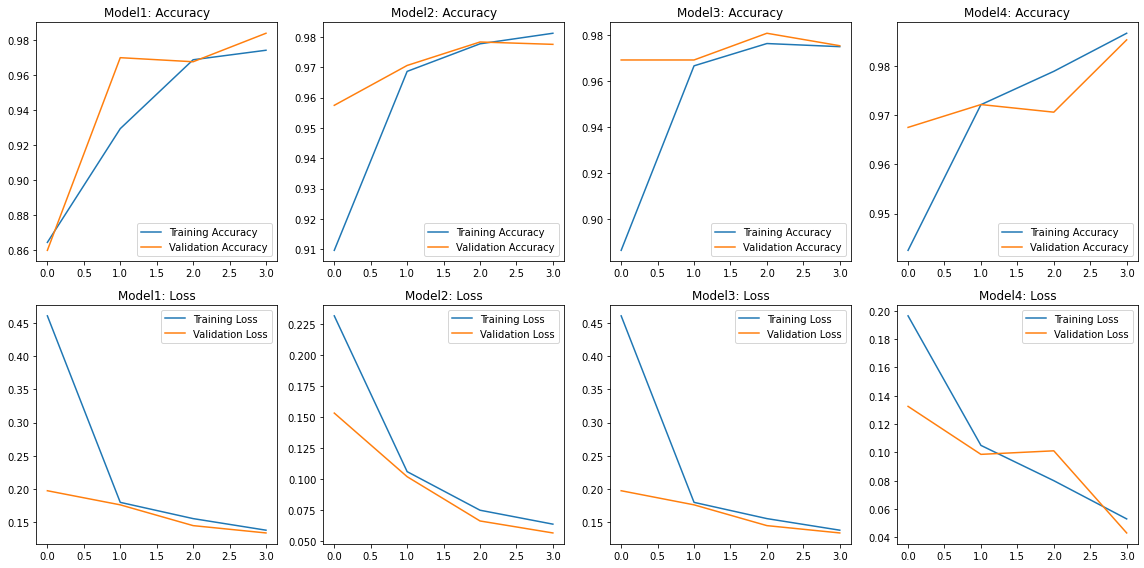

In [14]:
acc1 = history1.history['accuracy']
acc2 = history2.history['accuracy']
acc3 = history3.history['accuracy']
acc4 = history4.history['accuracy']

val_acc1 = history1.history['val_accuracy']
val_acc2 = history2.history['val_accuracy']
val_acc3 = history3.history['val_accuracy']
val_acc4 = history4.history['val_accuracy']

loss1 = history1.history['loss']
loss2 = history2.history['loss']
loss3 = history3.history['loss']
loss4 = history4.history['loss']

val_loss1 = history1.history['val_loss']
val_loss2 = history2.history['val_loss']
val_loss3 = history3.history['val_loss']
val_loss4 = history4.history['val_loss']

epochs_range = range(epochs)

fig, axs = plt.subplots(2, 4, constrained_layout=False, figsize=(16, 8))

axs[0,0].set_title('Model1: Accuracy')
axs[0,0].plot(epochs_range, acc1, label='Training Accuracy')
axs[0,0].plot(epochs_range, val_acc1, label='Validation Accuracy')
axs[0,0].legend(loc='lower right')

axs[0,1].set_title('Model2: Accuracy')
axs[0,1].plot(epochs_range, acc2, label='Training Accuracy')
axs[0,1].plot(epochs_range, val_acc2, label='Validation Accuracy')
axs[0,1].legend(loc='lower right')

axs[0,2].set_title('Model3: Accuracy')
axs[0,2].plot(epochs_range, acc3, label='Training Accuracy')
axs[0,2].plot(epochs_range, val_acc3, label='Validation Accuracy')
axs[0,2].legend(loc='lower right')

axs[0,3].set_title('Model4: Accuracy')
axs[0,3].plot(epochs_range, acc4, label='Training Accuracy')
axs[0,3].plot(epochs_range, val_acc4, label='Validation Accuracy')
axs[0,3].legend(loc='lower right')

axs[1,0].set_title('Model1: Loss')
axs[1,0].plot(epochs_range, loss1, label='Training Loss')
axs[1,0].plot(epochs_range, val_loss1, label='Validation Loss')
axs[1,0].legend(loc='upper right')

axs[1,1].set_title('Model2: Loss')
axs[1,1].plot(epochs_range, loss2, label='Training Loss')
axs[1,1].plot(epochs_range, val_loss2, label='Validation Loss')
axs[1,1].legend(loc='upper right')

axs[1,2].set_title('Model3: Loss')
axs[1,2].plot(epochs_range, loss1, label='Training Loss')
axs[1,2].plot(epochs_range, val_loss1, label='Validation Loss')
axs[1,2].legend(loc='upper right')

axs[1,3].set_title('Model4: Loss')
axs[1,3].plot(epochs_range, loss4, label='Training Loss')
axs[1,3].plot(epochs_range, val_loss4, label='Validation Loss')
axs[1,3].legend(loc='upper right')

fig.tight_layout()

### Test the models

In [16]:
# Perform tests
score1, acc1 = model1.evaluate(test_data, test_label, batch_size=100)
score2, acc2 = model2.evaluate(test_data, test_label, batch_size=100)
score3, acc3 = model3.evaluate(test_data, test_label, batch_size=100)
score4, acc4 = model4.evaluate(test_data, test_label, batch_size=100)

# Print test results in table
tableheader = ["Model #", "Accuracy"]
tabledata = list()
format_row = "{:<15}" * (len(tableheader))
print(format_row.format(*tableheader))
tabledata.append(("Model 1", str(acc1)))
tabledata.append(("Model 2", str(acc2)))
tabledata.append(("Model 3", str(acc3)))
tabledata.append(("Model 4", str(acc4)))
for row in tabledata:
    print(format_row.format(*row))
    
#Get the model with best result
best_acc=max([acc1,acc2,acc3,acc4])
if(best_acc==acc1):
    best_model=build_model1
elif(best_acc==acc2):
    best_model=build_model2
elif(best_acc==acc3):
    best_model=build_model3
elif(best_acc==acc4):
    best_model=build_model4

4/4 [==============================] - 0s 9ms/step - loss: 0.0379 - accuracy: 0.9941
Model #        Accuracy       
Model 1        0.9882698059082031
Model 2        0.9912023544311523
Model 3        0.9882698059082031
Model 4        0.9941349029541016


### Now try to apply Grid Search to best model to get the best hyperparameters.

#### Set parameters

In [17]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

epochs = [1,3,5,7,9] # epochs
batch_size=[25,50,100,200,500] # batch_size
k_folder=3
param_grid = dict(epochs=epochs, batch_size=batch_size)

#### Grid Search Function

In [18]:
def grid_search(model,param_grid,k_folder,train_data,train_label):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_folder, n_jobs=-1,return_train_score=True)
    grid_result = grid.fit(train_data, train_label)
    #the results
    print(f"Best Run: {grid_result.best_score_} with {grid_result.best_params_}")
    mean_train_score = grid_result.cv_results_['mean_train_score']
    mean_test_score = grid_result.cv_results_['mean_test_score']
    mean_fit_time=grid_result.cv_results_['mean_fit_time']
    params = grid_result.cv_results_['params']
    for train_score, test_score, fit_time, param in zip(mean_train_score, mean_test_score,mean_fit_time, params):
        print("running with:", param)
        print("mean train_score: ",{round(train_score, 4)})
        print("mean_test_score",{round(test_score, 4)})
        print("mean fit_time",{round(fit_time, 4)})
    return grid_result.best_params_["batch_size"],grid_result.best_params_["epochs"]

In [19]:
g_model = KerasClassifier(build_fn=best_model)

In [20]:
best_batch_size,best_epoch=grid_search(g_model,param_grid,k_folder,train_data,train_label)

Epoch 1/9
52/52 [==============================] - 2s 18ms/step - loss: 0.2458 - accuracy: 0.9207
Epoch 2/9
52/52 [==============================] - 1s 18ms/step - loss: 0.0817 - accuracy: 0.9783
Epoch 3/9
52/52 [==============================] - 1s 18ms/step - loss: 0.0498 - accuracy: 0.9854
Epoch 4/9
52/52 [==============================] - 1s 18ms/step - loss: 0.0300 - accuracy: 0.9910
Epoch 5/9
52/52 [==============================] - 1s 18ms/step - loss: 0.0246 - accuracy: 0.9917
Epoch 6/9
52/52 [==============================] - 1s 18ms/step - loss: 0.0259 - accuracy: 0.9913
Epoch 7/9
52/52 [==============================] - 1s 18ms/step - loss: 0.0302 - accuracy: 0.9903
Epoch 8/9
52/52 [==============================] - 1s 18ms/step - loss: 0.0231 - accuracy: 0.9918
Epoch 9/9
52/52 [==============================] - 1s 18ms/step - loss: 0.0096 - accuracy: 0.9973
Best Run: 0.9883898695309957 with {'batch_size': 100, 'epochs': 9}
running with: {'batch_size': 25, 'epochs': 1}
mean 

#### Use the best parameters to train again

In [21]:
timecost=0
model_b=best_model()
start = time.time()
history_b = model_b.fit(datagenerator.flow(train_data, train_label,batch_size=best_batch_size), 
                    epochs=best_epoch, steps_per_epoch=len(train_data) / best_batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / best_batch_size)
end = time.time()
timecost=end-start
score_b, acc_b = model_b.evaluate(test_data, test_label, batch_size=100)
print("The time cost of best CNN model is ", timecost)
print("The accuracy of best CNN model is ", acc_b)

Epoch 1/9
51/51 [==============================] - 12s 215ms/step - loss: 0.3337 - accuracy: 0.8460 - val_loss: 0.1304 - val_accuracy: 0.9691
Epoch 2/9
51/51 [==============================] - 11s 213ms/step - loss: 0.1079 - accuracy: 0.9772 - val_loss: 0.1147 - val_accuracy: 0.9660
Epoch 3/9
51/51 [==============================] - 11s 211ms/step - loss: 0.0785 - accuracy: 0.9772 - val_loss: 0.0705 - val_accuracy: 0.9791
Epoch 4/9
51/51 [==============================] - 11s 211ms/step - loss: 0.0758 - accuracy: 0.9805 - val_loss: 0.0541 - val_accuracy: 0.9830
Epoch 5/9
51/51 [==============================] - 11s 211ms/step - loss: 0.0595 - accuracy: 0.9794 - val_loss: 0.0572 - val_accuracy: 0.9783
Epoch 6/9
51/51 [==============================] - 11s 211ms/step - loss: 0.0525 - accuracy: 0.9854 - val_loss: 0.0489 - val_accuracy: 0.9838
Epoch 7/9
51/51 [==============================] - 11s 209ms/step - loss: 0.0327 - accuracy: 0.9893 - val_loss: 0.0475 - val_accuracy: 0.9869
Epoch 

### Now, trying to add attention mechanism in our model

In [22]:
from keras import backend
from keras.models import Model

#### Channel Attention

In [23]:
def channel_attention(input_feature, ratio=8):

    channel_axis = 1 if backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = layers.Dense(channel//ratio,
                             kernel_initializer='he_normal',
                             activation = 'relu',
                             use_bias=True,
                             bias_initializer='zeros')

    shared_layer_two = layers.Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)    
    avg_pool = layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = layers.Add()([avg_pool,max_pool])
    cbam_feature = layers.Activation('hard_sigmoid')(cbam_feature)

    if backend.image_data_format() == "channels_first":
        cbam_feature = layers.Permute((3, 1, 2))(cbam_feature)

    return layers.multiply([input_feature, cbam_feature])

#### Spatial_attention

In [24]:
def spatial_attention(input_feature):
    kernel_size = 7
    if backend.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = layers.Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = layers.Lambda(lambda x: backend.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = layers.Lambda(lambda x: backend.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = layers.Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    activation = 'hard_sigmoid',
                    strides=1,
                    padding='same',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)

    if backend.image_data_format() == "channels_first":
        cbam_feature = layers.Permute((3, 1, 2))(cbam_feature)

    return layers.multiply([input_feature, cbam_feature])

#### Convolutional Block Attention Module

In [25]:
def cbam_block(cbam_feature,ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature, )
    return cbam_feature

#### Build model with attention layer

In [26]:
def modelWithAttention():
    inputs=layers.Input(shape=(img_height,img_width,img_channels))
    
    rescalling=layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3))(inputs)
    Conv2D_1=layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',name="Aconv1")(rescalling)
    
    cbam=cbam_block(Conv2D_1)
    
    MaxPooling2D_1=layers.MaxPooling2D(pool_size=(2,2),name="Amaxp1")(cbam)
    
    Conv2D_2=layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',name="Aconv2")(MaxPooling2D_1)
    MaxPooling2D_2=layers.MaxPooling2D(pool_size=(2,2),name="Amaxp2")(Conv2D_2)
    
    Conv2D_3=layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',name="Aconv3")(MaxPooling2D_2)
    MaxPooling2D_3= layers.MaxPooling2D(pool_size=(2,2),name="Amaxp3")(Conv2D_3)
    
    Conv2D_4=layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',name="Aconv4")(MaxPooling2D_3)
    MaxPooling2D_4=layers.MaxPooling2D(pool_size=(2,2),name="Amaxp4")(Conv2D_4)
    flatten=layers.Flatten()(MaxPooling2D_4)
    dropout=layers.Dropout(rate=0.5)(flatten)
    dense1=layers.Dense(units=128,activation='relu')(dropout)
    output=layers.Dense(units=1,activation='sigmoid')(dense1)

    model= Model(outputs=output,inputs=inputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
model_withAttention=modelWithAttention()
model_withAttention.summary()
start = time.time()
history_a = model_withAttention.fit(datagenerator.flow(train_data, train_label,batch_size=best_batch_size), 
                    epochs=best_epoch, steps_per_epoch=len(train_data) / best_batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / best_batch_size)
end = time.time()
timecost_a=end-start

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 100, 100, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Aconv1 (Conv2D)                 (None, 100, 100, 16) 448         rescaling_6[0][0]                
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 16)           0           Aconv1[0][0]                     
______________________________________________________________________________________________

In [28]:
score_a, acc_a = model_withAttention.evaluate(test_data, test_label, batch_size=best_batch_size)

4/4 [==============================] - 0s 21ms/step - loss: 0.0227 - accuracy: 0.9912


In [29]:
print("The accuracy of CNN model with attention mechanism is ", acc_a)

The accuracy of CNN model with attention mechanism is  0.9912023544311523


### We can visualize each layer of models.

#### We use Grad Cam to help us to visualize

In [30]:
import gradcam

In [31]:
test_img_array = gradcam.get_img_array("data/trainvalidate/WithMask/148.png",(img_height,img_width))
test_img=cv2.imread("data/trainvalidate/WithMask/148.png", cv2.IMREAD_UNCHANGED)
test_img = test_img[:, :, [2,1,0]]

#### Original image

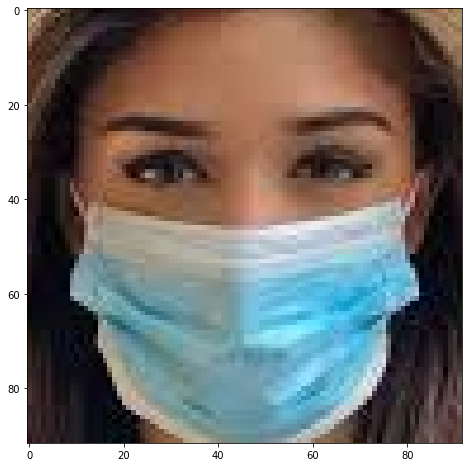

In [32]:
plt.imshow(test_img)
plt.show()

#### Heat Map

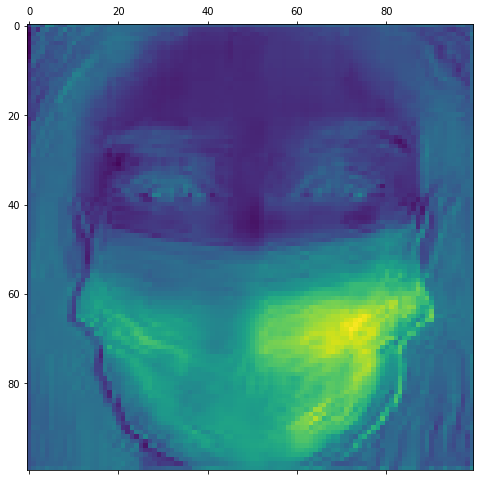

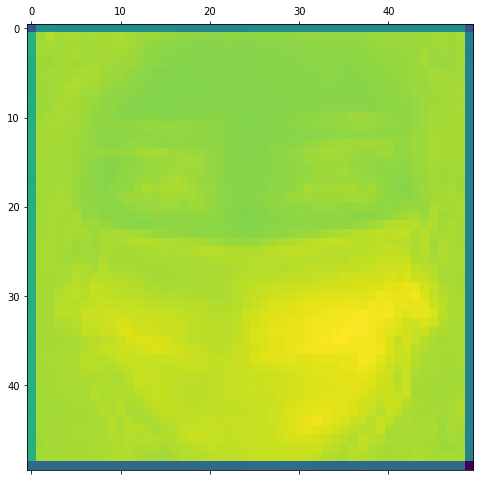

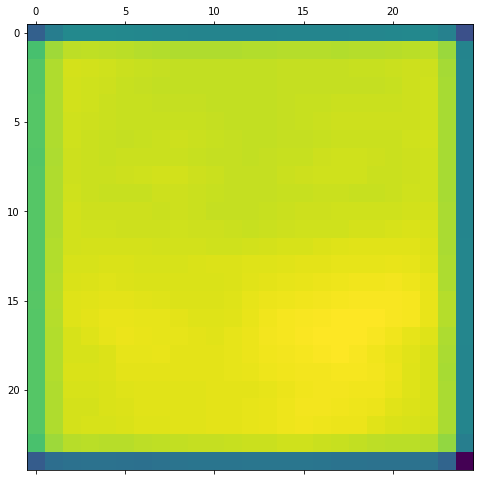

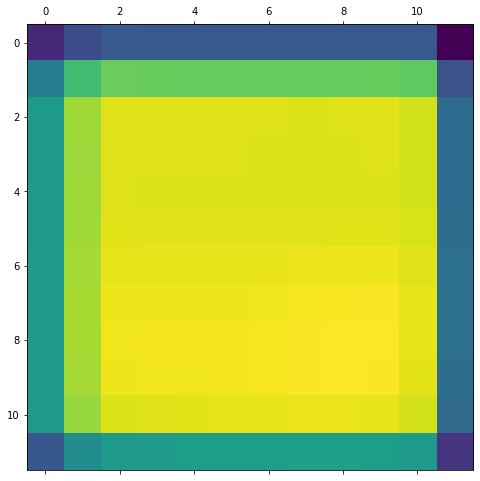

In [42]:
heatmap1 = gradcam.make_gradcam_heatmap(test_img_array/255, model_b, "conv1")
heatmap3 = gradcam.make_gradcam_heatmap(test_img_array/255, model_b, "conv2")
heatmap5 = gradcam.make_gradcam_heatmap(test_img_array/255, model_b, "conv3")
heatmap7 = gradcam.make_gradcam_heatmap(test_img_array/255, model_b, "conv4")
plt.matshow(heatmap1)
plt.matshow(heatmap3)
plt.matshow(heatmap5)
plt.matshow(heatmap7)
plt.show()

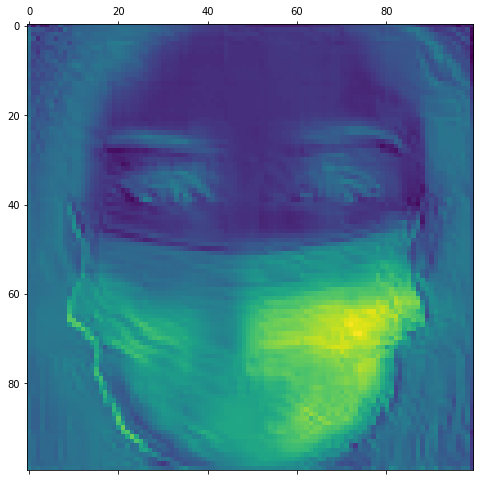

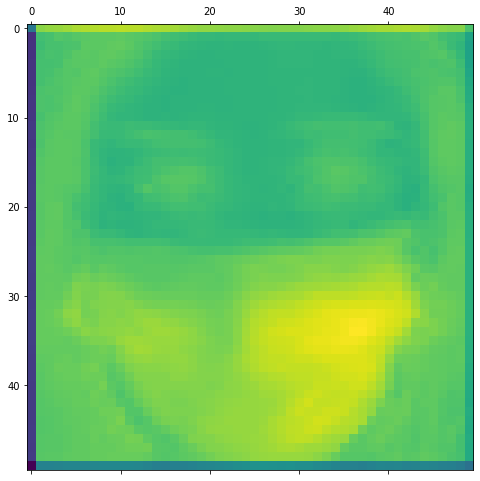

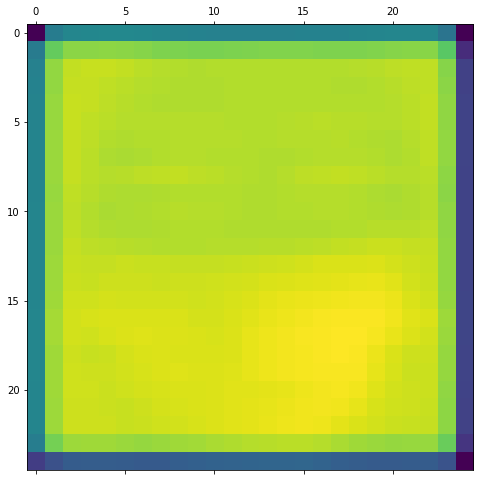

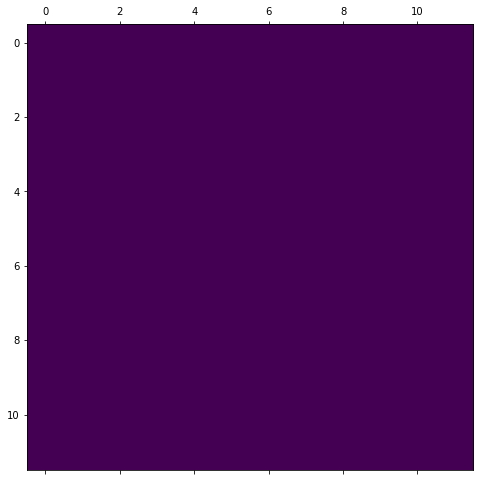

In [43]:
Aheatmap1 = gradcam.make_gradcam_heatmap(test_img_array/255, model_withAttention, "Aconv1")
Aheatmap3 = gradcam.make_gradcam_heatmap(test_img_array/255, model_withAttention, "Aconv2")
Aheatmap5 = gradcam.make_gradcam_heatmap(test_img_array/255, model_withAttention, "Aconv3")
Aheatmap7 = gradcam.make_gradcam_heatmap(test_img_array/255, model_withAttention, "Aconv4")
plt.matshow(Aheatmap1)
plt.matshow(Aheatmap3)
plt.matshow(Aheatmap5)
plt.matshow(Aheatmap7)
plt.show()

### Test random images of multiple people

Found 5 faces as follows: 2 wearing a mask, 3 not wearing a mask.


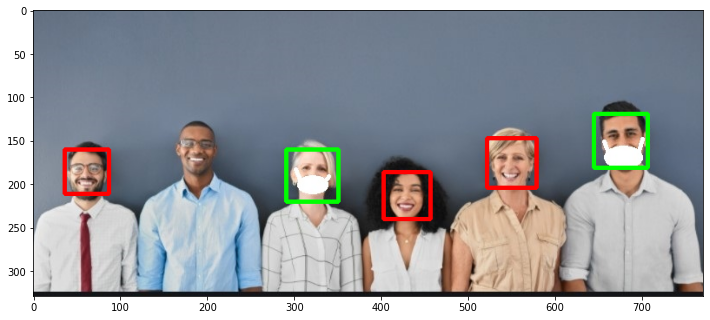

In [49]:
# Set image location
imagePath = "data/test/2.png"

# Create the haar cascade classifier
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Read the image
image = cv2.imread(imagePath)
b,g,r = cv2.split(image)       # get b, g, r
image = cv2.merge([r,g,b])     # switch to r, g, b
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect all the face coordinates in the image
faces_coords = faceCascade.detectMultiScale(
    #gray,
    image,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(10, 10),
    #flags = cv2.cv.CV_HAAR_SCALE_IMAGE
)

# retrieve each face then place in new array
faces = []
for (x, y, w, h) in faces_coords:
    faces.append(image[y:y+h, x:x+w])
    #cv2.imshow("Faces found", face)
    #cv2.waitKey(0)

# iterate over each face in the photo and check if it has a mask on, then store result in new array
mask_counter = no_mask_counter = 0
mask_location = []
for num, face in enumerate(faces):
    img1=cv2.resize(face,(img_height, img_width),interpolation=cv2.INTER_CUBIC)
    result = model3.predict(np.array([img1]))
    if result > 0.5:
        mask_counter += 1
        mask_location.append(num)
    else:
        no_mask_counter += 1

# iterate over each face then draw a rectangle around it, red if no mask, green if with mask
for num, (x, y, w, h) in enumerate(faces_coords):
    if num in mask_location:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)
    else:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)

print(f"Found {len(faces)} faces as follows: {mask_counter} wearing a mask, {no_mask_counter} not wearing a mask.")
plt.imshow(image)